In [ ]:
from metrics import *
from beamforming import *

# Metrics for testing set

## Computing images from model

In [1]:
from torch.utils.data import DataLoader
import torch
import numpy as np
from pathlib import Path
import pandas as pd
import guided_diffusion_v3 as gd


gen_folder = Path(r'C:\Users\u_imagenes\Documents\smerino\testing\generated_v2')
input_folder = r'C:\Users\u_imagenes\Documents\smerino\testing\input'
output_folder = r'C:\Users\u_imagenes\Documents\smerino\testing\target_enh'
save_dir = Path('.\weights')/'v13A'
training_epochs = 10

device = torch.device("cuda:0" if torch.cuda.is_available() else torch.device('cpu'))


In [24]:
BATCH_SIZE = 4 # CHANGE TO 32

data = gd.CustomDataset(input_folder, output_folder, transform=True)
dataloader = DataLoader(data, batch_size=BATCH_SIZE, shuffle=False, drop_last=True)
x_sample,y_sample = next(iter(dataloader))
x_sample = x_sample.to(device)
print(x_sample.shape)
data.input_file_list[-4:]

torch.Size([4, 2, 800, 128])


['simu12483.npy', 'simu12487.npy', 'simu12494.npy', 'simu12496.npy']

In [4]:
def create_gaussian_diffusion(
    *,
    steps=1000,
    learn_sigma=False,
    sigma_small=False,
    noise_schedule="linear",
    use_kl=False,
    predict_xstart=False,
    rescale_timesteps=False,
    rescale_learned_sigmas=False,
    timestep_respacing="",
):
    betas = gd.get_named_beta_schedule(noise_schedule, steps)
    if use_kl:
        loss_type = gd.LossType.RESCALED_KL
    elif rescale_learned_sigmas:
        loss_type = gd.LossType.RESCALED_MSE
    else:
        loss_type = gd.LossType.MSE
    if not timestep_respacing:
        timestep_respacing = [steps]
    return gd.SpacedDiffusion(
        use_timesteps=gd.space_timesteps(steps, timestep_respacing),
        betas=betas,
        model_mean_type=(
            gd.ModelMeanType.EPSILON if not predict_xstart else gd.ModelMeanType.START_X
        ),
        model_var_type=(
            (
                gd.ModelVarType.FIXED_LARGE
                if not sigma_small
                else gd.ModelVarType.FIXED_SMALL
            )
            if not learn_sigma
            else gd.ModelVarType.LEARNED_RANGE
        ),
        loss_type=loss_type,
        rescale_timesteps=rescale_timesteps,
    )

diffusion = create_gaussian_diffusion()

In [5]:
from model7 import UNETv13

model13A = UNETv13(residual=False, attention_res=[]).to(device)
model13A.load_state_dict(torch.load(save_dir/f"model_{training_epochs}.pth", map_location=device))
print("Num params: ", sum(p.numel() for p in model13A.parameters()))

Num params:  32676097


In [6]:
id_file = 0
x,y = next(iter(dataloader))
y = y.to(device)
x = x.to(device)
y_gen = diffusion.p_sample_loop(model13A,y.shape,x, progress=True, clip_denoised=True)
name = (data.input_file_list[id_file])
np.save(gen_folder / name, y_gen.squeeze(0).cpu().detach().numpy())

  0%|          | 0/1000 [00:00<?, ?it/s]

In [7]:
y_gen.shape

torch.Size([16, 1, 800, 128])

In [8]:
batch_number = 0
for id, sample in enumerate(y_gen):
    name = (data.input_file_list[batch_number*BATCH_SIZE + id])
    np.save(gen_folder/name, sample.cpu().detach().numpy())

In [25]:
len(dataloader)

625

In [27]:
processed_batches = 0
batch_number = 0 # initialization
for x, y in dataloader:  # x: images
    x = x.to(device)
    if batch_number >= processed_batches:
        y_gen = diffusion.p_sample_loop(model13A,y.shape,x, progress=True, clip_denoised=True)
        print(f'Saving batch {batch_number}')
        for id, sample in enumerate(y_gen):
            name = (data.input_file_list[batch_number * BATCH_SIZE + id])
            np.save(gen_folder / name, sample.cpu().detach().numpy())
    batch_number += 1

  0%|          | 0/1000 [00:00<?, ?it/s]

Saving batch 624


## Computing metrics

In [28]:
import os
import pandas as pd
df = pd.read_csv('testing_params.csv')
df.head()

,id,r,cx,cz,c
0,14,0.008,-0.006,0.0550,1420.0
1,15,0.006,-0.008,0.0575,1570.0
2,16,0.006,-0.008,0.0475,1480.0
3,21,0.006,0.012,0.0600,1590.0
4,24,0.002,-0.004,0.0575,1420.0


In [29]:
from beamforming import *
import pickle
from pathlib import Path
gen_folder = Path(r'C:\Users\u_imagenes\Documents\smerino\testing\generated_v2')
testing_file_list = os.listdir(gen_folder)
input_file_list = os.listdir(input_folder)
with open('common_params.pkl','rb') as f:
    P = pickle.load(f)
depths = np.linspace(P.grid_zlims[0], P.grid_zlims[1], num=800)
laterals = np.linspace(P.grid_xlims[0], P.grid_xlims[1], num=128)
grid = make_pixel_grid_from_pos(x_pos=laterals, z_pos=depths)

simu00064.npy


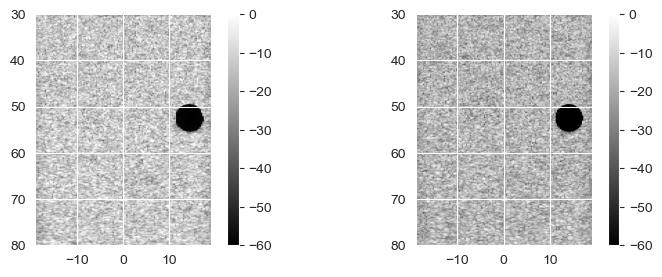

In [30]:
from matplotlib import pyplot as plt

file = input_file_list[10]
print(file)
bmode_output = np.load(gen_folder / file).squeeze()
bmode_output = (bmode_output + 1) * 30 - 60

target_folder = Path(r'C:\Users\u_imagenes\Documents\smerino\testing\target_enh')
target = np.load(target_folder / file)
target = (target * 60) - 60

extent = [laterals[0] * 1e3, laterals[-1] * 1e3, depths[-1] * 1e3, depths[0] * 1e3]
plt.figure(figsize=(9, 3))
plt.subplot(1, 2, 1)
plt.imshow(bmode_output, cmap="gray", vmin=-60, vmax=0, extent=extent, origin="upper")
plt.colorbar()
plt.subplot(1, 2, 2)
plt.imshow(target, cmap="gray", vmin=-60, vmax=0, extent=extent, origin="upper")
plt.colorbar()
plt.show()


In [31]:
from metrics import compute_metrics
for id, file in enumerate(testing_file_list):
    bmode_output = np.load(gen_folder/file).squeeze()
    bmode_output = (bmode_output + 1) * 30 - 60
    cx = df.loc[id, "cx"]
    cz = df.loc[id, "cz"]
    r = df.loc[id, "r"]
    contrast, cnr, gcnr, snr = compute_metrics(cx, cz, r, bmode_output, grid)    
    df.loc[id, "contrast"] = contrast
    df.loc[id, "cnr"] = cnr
    df.loc[id, "snr"] = snr
    df.loc[id, "gcnr"] = gcnr
df.to_csv('diffusion_metrics_v2.csv')

In [32]:
df

,id,r,cx,cz,c,contrast,cnr,snr,gcnr
0,14,0.008,-0.006,0.0550,1420.0,-47.655315,-1.623595,1.630349,0.999635
1,15,0.006,-0.008,0.0575,1570.0,-51.376305,-1.812775,1.817681,1.000000
2,16,0.006,-0.008,0.0475,1480.0,-52.769256,-1.831594,1.835814,1.000000
3,21,0.006,0.012,0.0600,1590.0,-46.857033,-1.493264,1.500076,0.981481
4,24,0.002,-0.004,0.0575,1420.0,-26.680913,-1.953466,2.050604,0.988095
...,...,...,...,...,...,...,...,...,...
2495,12472,0.002,0.006,0.0700,1580.0,-39.634435,-1.564025,1.580511,1.000000
2496,12483,0.002,-0.012,0.0500,1450.0,-44.788203,-1.471664,1.480379,1.000000
2497,12487,0.002,0.000,0.0425,1540.0,-43.860421,-1.578933,1.589123,1.000000
2498,12494,0.006,0.014,0.0550,1420.0,-41.053238,-1.511030,1.524534,0.999674


In [ ]:
das_folder = Path(r'E:\target_from_raw_subsampled')
for id, file in enumerate(testing_file_list):
    bmode = np.load(das_folder / file)
    bmode = (bmode * 60) - 60
    cx = df.loc[id, "cx"]
    cz = df.loc[id, "cz"]
    r = df.loc[id, "r"]
    contrast, cnr, gcnr, snr = compute_metrics(cx, cz, r, bmode, grid)
    df.loc[id, "contrast"] = contrast
    df.loc[id, "cnr"] = cnr
    df.loc[id, "snr"] = snr
    df.loc[id, "gcnr"] = gcnr
df.head()


,id,r,cx,cz,c,contrast,cnr,snr,gcnr
0,14,0.008,-0.006,0.0550,1420.0,-8.656895,-0.994161,1.656063,0.589678
1,15,0.006,-0.008,0.0575,1570.0,-10.210251,-1.088383,1.626962,0.670949
2,16,0.006,-0.008,0.0475,1480.0,-8.856369,-1.040163,1.712399,0.607031
3,21,0.006,0.012,0.0600,1590.0,-10.624313,-1.109480,1.622815,0.681158
4,24,0.002,-0.004,0.0575,1420.0,-8.459663,-0.987783,1.648203,0.642703


In [ ]:
df.set_index('id', inplace=True)
df

,r,cx,cz,c,contrast,cnr,snr,gcnr
id,,,,,,,,
14,0.008,-0.006,0.0550,1420.0,-8.656895,-0.994161,1.656063,0.589678
15,0.006,-0.008,0.0575,1570.0,-10.210251,-1.088383,1.626962,0.670949
16,0.006,-0.008,0.0475,1480.0,-8.856369,-1.040163,1.712399,0.607031
21,0.006,0.012,0.0600,1590.0,-10.624313,-1.109480,1.622815,0.681158
24,0.002,-0.004,0.0575,1420.0,-8.459663,-0.987783,1.648203,0.642703
...,...,...,...,...,...,...,...,...
12472,0.002,0.006,0.0700,1580.0,-7.610337,-0.846744,1.521472,0.596601
12483,0.002,-0.012,0.0500,1450.0,-5.786645,-0.853999,1.956676,0.666667
12487,0.002,0.000,0.0425,1540.0,-7.082872,-0.831399,1.579493,0.686679


In [ ]:
df.to_csv('das_metrics.csv')

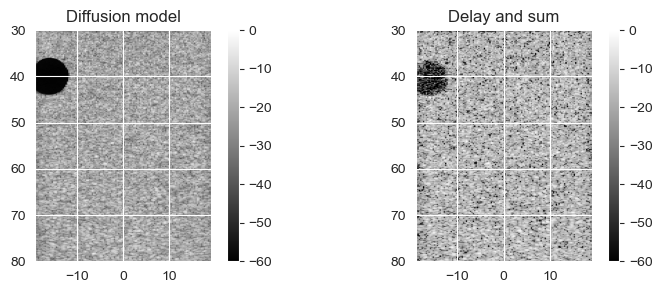

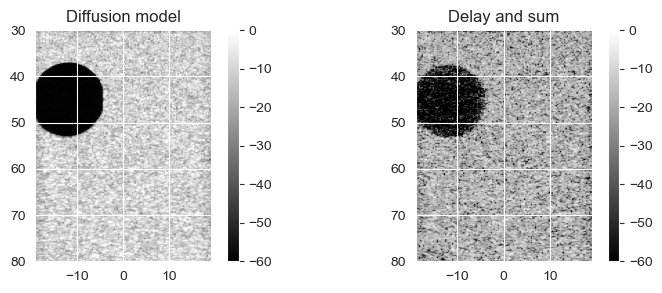

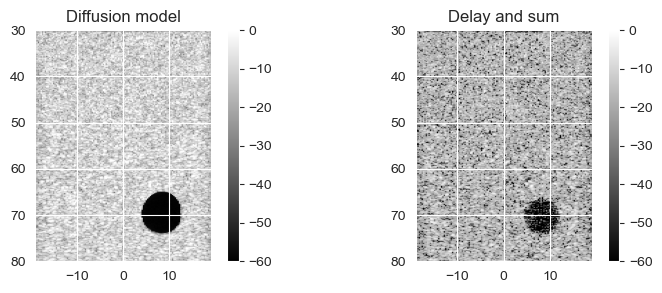

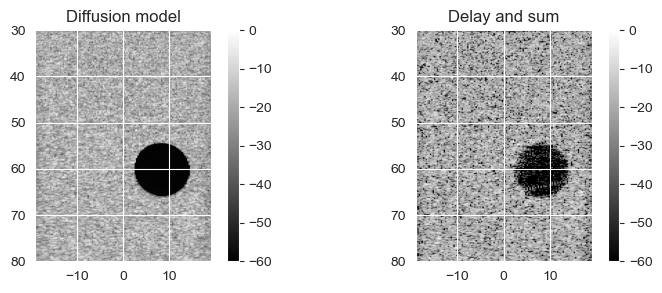

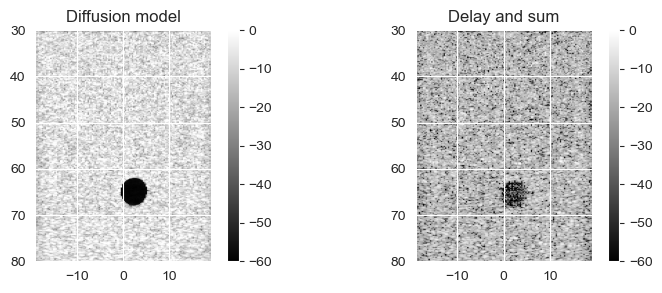

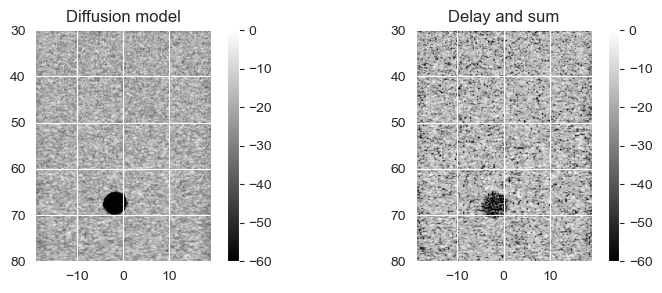

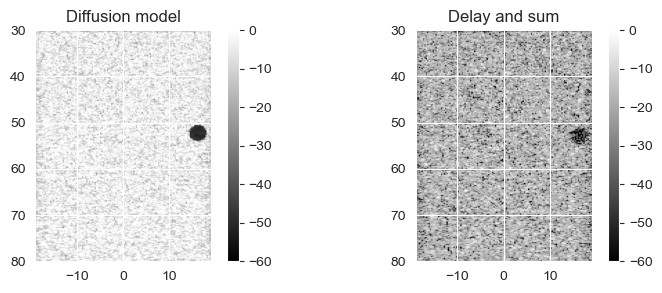

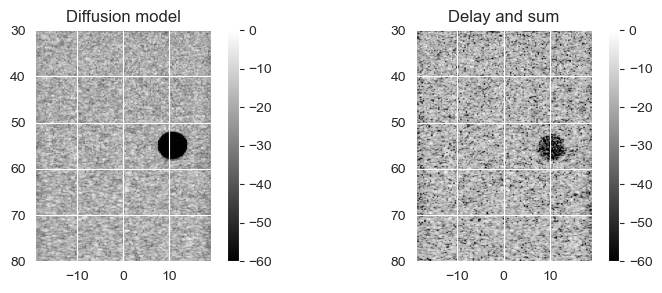

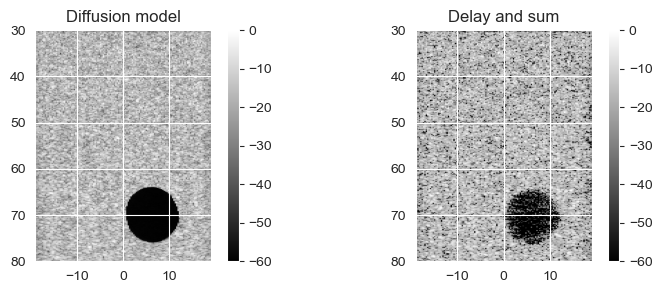

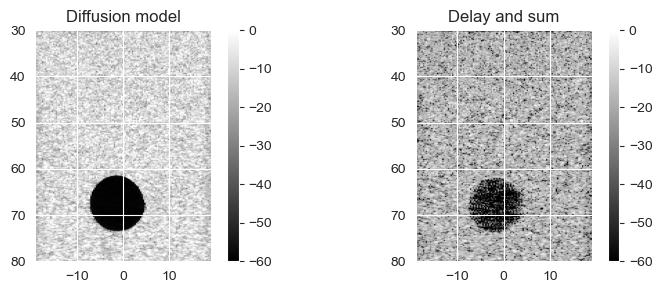

In [33]:
from matplotlib import pyplot as plt
gen_folder = Path(r'C:\Users\u_imagenes\Documents\smerino\testing\generated_v2')
das_folder = Path(r'C:\Users\u_imagenes\Documents\smerino\das_full')
testing_file_list = os.listdir(gen_folder)

for file in testing_file_list[40:50]:
    bmode_output = np.load(gen_folder / file).squeeze()
    bmode_output = (bmode_output + 1) * 30 - 60

    target = np.load(das_folder / file)
    target = (target * 60) - 60

    extent = [laterals[0] * 1e3, laterals[-1] * 1e3, depths[-1] * 1e3, depths[0] * 1e3]
    plt.figure(figsize=(9, 3))
    plt.subplot(1, 2, 1)
    plt.imshow(bmode_output, cmap="gray", vmin=-60, vmax=0, extent=extent, origin="upper")
    plt.colorbar()
    plt.title('Diffusion model')

    plt.subplot(1, 2, 2)
    plt.imshow(target, cmap="gray", vmin=-60, vmax=0, extent=extent, origin="upper")
    plt.colorbar()
    plt.title('Delay and sum')

    plt.show()

# Comparing results

In [34]:
import seaborn as sns
import pandas as pd

In [35]:
df_das = pd.read_csv('das_metrics.csv',index_col='id')
df_diff = pd.read_csv('diffusion_metrics_v2.csv', index_col='id')
df_das.head()

,r,cx,cz,c,contrast,cnr,snr,gcnr
id,,,,,,,,
14,0.008,-0.006,0.0550,1420.0,-8.656895,-0.994161,1.656063,0.589678
15,0.006,-0.008,0.0575,1570.0,-10.210251,-1.088383,1.626962,0.670949
16,0.006,-0.008,0.0475,1480.0,-8.856369,-1.040163,1.712399,0.607031
21,0.006,0.012,0.0600,1590.0,-10.624313,-1.109480,1.622815,0.681158
24,0.002,-0.004,0.0575,1420.0,-8.459663,-0.987783,1.648203,0.642703


In [36]:
df_das['r'] = df_das['r']*1000
df_diff['r'] = df_diff['r']*1000

In [37]:
df_das['cnr'] = df_das['cnr']
df_diff['cnr'] = df_diff['cnr']

C:\Users\u_imagenes\AppData\Local\Temp\ipykernel_19584\3681270775.py:6: MatplotlibDeprecationWarning: An artist whose label starts with an underscore was passed to legend(); such artists will no longer be ignored in the future.  To suppress this warning, explicitly filter out such artists, e.g. with `[art for art in artists if not art.get_label().startswith('_')]`.
  plt.legend(['DAS','_','Diff'])


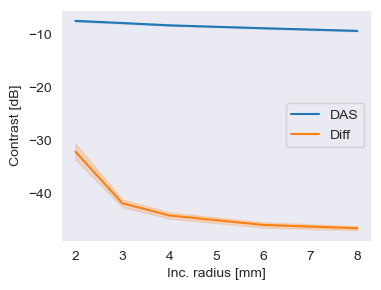

In [38]:
plt.figure(figsize=(4,3))
sns.lineplot(data=df_das, x='r', y='contrast')
sns.lineplot(data=df_diff, x='r', y='contrast')
plt.ylabel('Contrast [dB]')
plt.xlabel('Inc. radius [mm]')
plt.legend(['DAS','_','Diff'])
plt.grid()
plt.show()

C:\Users\u_imagenes\AppData\Local\Temp\ipykernel_19584\1747426968.py:6: MatplotlibDeprecationWarning: An artist whose label starts with an underscore was passed to legend(); such artists will no longer be ignored in the future.  To suppress this warning, explicitly filter out such artists, e.g. with `[art for art in artists if not art.get_label().startswith('_')]`.
  plt.legend(['DAS', '_', 'Diff'])


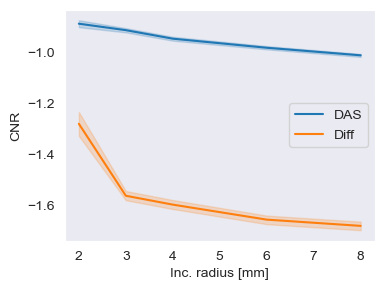

In [39]:
plt.figure(figsize=(4,3))
sns.lineplot(data=df_das, x='r', y='cnr')
sns.lineplot(data=df_diff, x='r', y='cnr')
plt.ylabel('CNR')
plt.xlabel('Inc. radius [mm]')
plt.legend(['DAS', '_', 'Diff'])
plt.grid()
plt.show()

C:\Users\u_imagenes\AppData\Local\Temp\ipykernel_19584\3083733976.py:6: MatplotlibDeprecationWarning: An artist whose label starts with an underscore was passed to legend(); such artists will no longer be ignored in the future.  To suppress this warning, explicitly filter out such artists, e.g. with `[art for art in artists if not art.get_label().startswith('_')]`.
  plt.legend(['DAS', '_', 'Diff'])


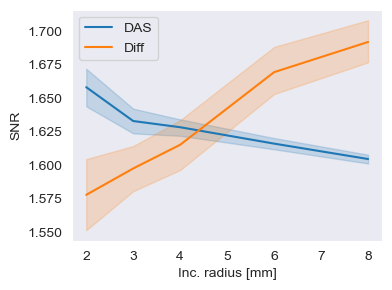

In [40]:
plt.figure(figsize=(4,3))
sns.lineplot(data=df_das, x='r', y='snr')
sns.lineplot(data=df_diff, x='r', y='snr')
plt.ylabel('SNR')
plt.xlabel('Inc. radius [mm]')
plt.legend(['DAS', '_', 'Diff'])
plt.grid()
plt.show()


C:\Users\u_imagenes\AppData\Local\Temp\ipykernel_19584\2262025728.py:6: MatplotlibDeprecationWarning: An artist whose label starts with an underscore was passed to legend(); such artists will no longer be ignored in the future.  To suppress this warning, explicitly filter out such artists, e.g. with `[art for art in artists if not art.get_label().startswith('_')]`.
  plt.legend(['DAS', '_', 'Diff'])


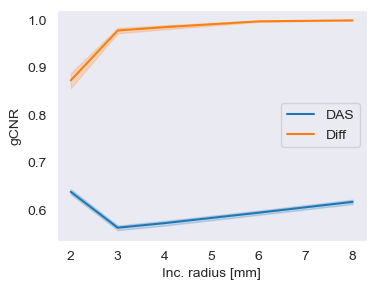

In [41]:
plt.figure(figsize=(4,3))
sns.lineplot(data=df_das, x='r', y='gcnr')
sns.lineplot(data=df_diff, x='r', y='gcnr')
plt.ylabel('gCNR')
plt.xlabel('Inc. radius [mm]')
plt.legend(['DAS', '_', 'Diff'])
plt.grid()
plt.show()


### SoS

C:\Users\u_imagenes\AppData\Local\Temp\ipykernel_19584\1545589895.py:6: MatplotlibDeprecationWarning: An artist whose label starts with an underscore was passed to legend(); such artists will no longer be ignored in the future.  To suppress this warning, explicitly filter out such artists, e.g. with `[art for art in artists if not art.get_label().startswith('_')]`.
  plt.legend(['DAS', '_', 'Diff'])


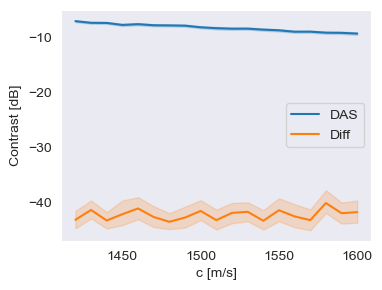

C:\Users\u_imagenes\AppData\Local\Temp\ipykernel_19584\1545589895.py:14: MatplotlibDeprecationWarning: An artist whose label starts with an underscore was passed to legend(); such artists will no longer be ignored in the future.  To suppress this warning, explicitly filter out such artists, e.g. with `[art for art in artists if not art.get_label().startswith('_')]`.
  plt.legend(['DAS', '_', 'Diff'])


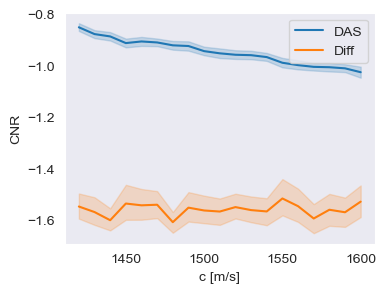

C:\Users\u_imagenes\AppData\Local\Temp\ipykernel_19584\1545589895.py:22: MatplotlibDeprecationWarning: An artist whose label starts with an underscore was passed to legend(); such artists will no longer be ignored in the future.  To suppress this warning, explicitly filter out such artists, e.g. with `[art for art in artists if not art.get_label().startswith('_')]`.
  plt.legend(['DAS', '_', 'Diff'])


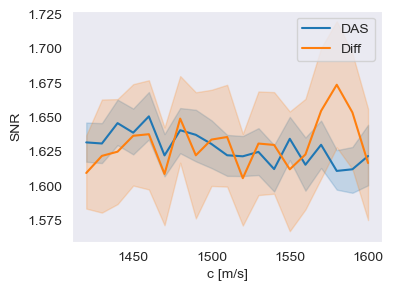

C:\Users\u_imagenes\AppData\Local\Temp\ipykernel_19584\1545589895.py:31: MatplotlibDeprecationWarning: An artist whose label starts with an underscore was passed to legend(); such artists will no longer be ignored in the future.  To suppress this warning, explicitly filter out such artists, e.g. with `[art for art in artists if not art.get_label().startswith('_')]`.
  plt.legend(['DAS', '_', 'Diff'])


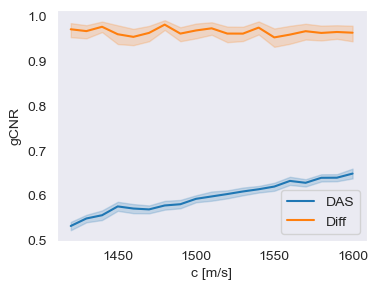

In [43]:
plt.figure(figsize=(4, 3))
sns.lineplot(data=df_das, x='c', y='contrast')
sns.lineplot(data=df_diff, x='c', y='contrast')
plt.ylabel('Contrast [dB]')
plt.xlabel('c [m/s]')
plt.legend(['DAS', '_', 'Diff'])
plt.grid()
plt.show()
plt.figure(figsize=(4, 3))
sns.lineplot(data=df_das, x='c', y='cnr')
sns.lineplot(data=df_diff, x='c', y='cnr')
plt.ylabel('CNR')
plt.xlabel('c [m/s]')
plt.legend(['DAS', '_', 'Diff'])
plt.grid()
plt.show()
plt.figure(figsize=(4, 3))
sns.lineplot(data=df_das, x='c', y='snr')
sns.lineplot(data=df_diff, x='c', y='snr')
plt.ylabel('SNR')
plt.xlabel('c [m/s]')
plt.legend(['DAS', '_', 'Diff'])
plt.grid()
plt.show()

plt.figure(figsize=(4, 3))
sns.lineplot(data=df_das, x='c', y='gcnr')
sns.lineplot(data=df_diff, x='c', y='gcnr')
plt.ylabel('gCNR')
plt.xlabel('c [m/s]')
plt.legend(['DAS', '_', 'Diff'])
plt.grid()
plt.show()


In [45]:
df_diff.mean()

Unnamed: 0    1249.500000
r                4.598000
cx               0.000018
cz               0.054521
c             1509.028000
contrast       -42.237515
cnr             -1.557862
snr              1.630350
gcnr             0.966419
dtype: float64

In [46]:
df_das.mean()


r              4.598000
cx             0.000018
cz             0.054521
c           1509.028000
contrast      -8.351989
cnr           -0.946982
snr            1.627869
gcnr           0.596264
dtype: float64

In [50]:
# with open("common_params.pkl", "wb") as f:
#     pickle.dump(P.__dict__, f)

### IMAGE

In [ ]:
from guided_diffusion import *
from torch.utils.data import DataLoader
import torch
import numpy as np
from pathlib import Path
device = torch.device("cuda:0" if torch.cuda.is_available() else torch.device('cpu'))
input_folder = r'C:\Users\u_imagenes\Documents\smerino\training\input'
output_folder = r'C:\Users\u_imagenes\Documents\smerino\training\target_enh'

In [ ]:
data = CustomDataset(input_folder, output_folder, transform=True)


In [ ]:
from model4 import UNETv10
device = torch.device("cuda:0" if torch.cuda.is_available() else torch.device('cpu'))
save_dir = r'.\weights_v10_T1000'
training_epochs = 200
model = UNETv10(in_channels=3, out_channels=1).to(device)
model.load_state_dict(torch.load(f"{save_dir}\\model_{training_epochs}.pth", map_location=device))

<All keys matched successfully>

In [ ]:
# NOISE SCHEDULE
T = 1000
# Pre-calculate different terms for closed form
beta, gamma = linear_beta_schedule(timesteps=T, start=1e-4, end=0.03, device=device)

In [ ]:
id_file = 33
data.input_file_list[id_file]

'simu00040.npy'

In [ ]:
x,y = data.__getitem__(id_file)
y = y.unsqueeze(0).to(device)
x = x.unsqueeze(0).to(device)
y_gen, intermediate = sample_image_cond(x, model, beta, num_intermediate=1)

100%|██████████| 1000/1000 [00:17<00:00, 57.73it/s]


In [ ]:
data.input_file_list[id_file]

'simu00040.npy'

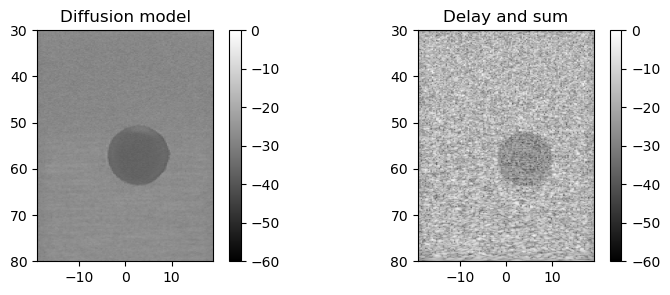

In [ ]:
from matplotlib import pyplot as plt

das_folder = Path(r'E:\target_from_raw_subsampled')
testing_file_list = os.listdir(gen_folder)

bmode_output = y_gen.cpu().detach().squeeze()
bmode_output = (bmode_output + 1) * 30 - 60

target = np.load(das_folder / data.input_file_list[id_file])
target = (target * 60) - 60

extent = [laterals[0] * 1e3, laterals[-1] * 1e3, depths[-1] * 1e3, depths[0] * 1e3]
plt.figure(figsize=(9, 3))
plt.subplot(1, 2, 1)
plt.imshow(bmode_output, cmap="gray", vmin=-60, vmax=0, extent=extent, origin="upper")
plt.colorbar()
plt.title('Diffusion model')

plt.subplot(1, 2, 2)
plt.imshow(target, cmap="gray", vmin=-60, vmax=0, extent=extent, origin="upper")
plt.colorbar()
plt.title('Delay and sum')

plt.show()

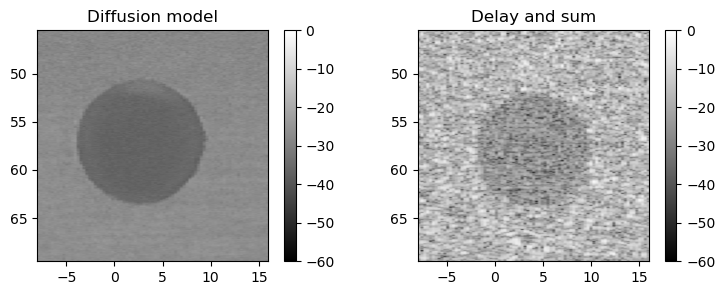

In [ ]:
h5_dir = r'E:\simulatedCystDataset\raw_0.0Att'
P = LoadDataParams(h5_dir=h5_dir, simu_name=f'simu00040')
cx = P.pos_lat*1000
cz = P.pos_ax*1000
r = P.radius*1000

plt.figure(figsize=(9, 3))
plt.subplot(1, 2, 1)
plt.imshow(bmode_output, cmap="gray", vmin=-60, vmax=0, extent=extent, origin="upper")
plt.xlim(cx-r*2, cx+r*2)
plt.ylim(cz+r*2, cz-r*2)
plt.colorbar()
plt.title('Diffusion model')

plt.subplot(1, 2, 2)
plt.imshow(target, cmap="gray", vmin=-60, vmax=0, extent=extent, origin="upper")
plt.xlim(cx-r*2, cx+r*2)
plt.ylim(cz+r*2, cz-r*2)
plt.colorbar()
plt.title('Delay and sum')

plt.show()

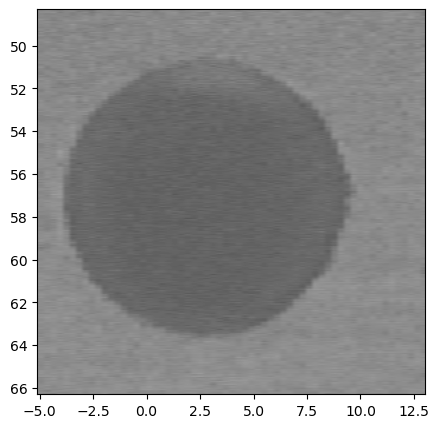

In [ ]:
plt.figure(figsize=(5, 5))
plt.imshow(bmode_output, cmap="gray", vmin=-60, vmax=0, extent=extent, origin="upper")
plt.xlim(-5.1, 13)
plt.ylim(66.3, 48.3)
plt.axis()
plt.savefig('DDPM_simu00040.png')

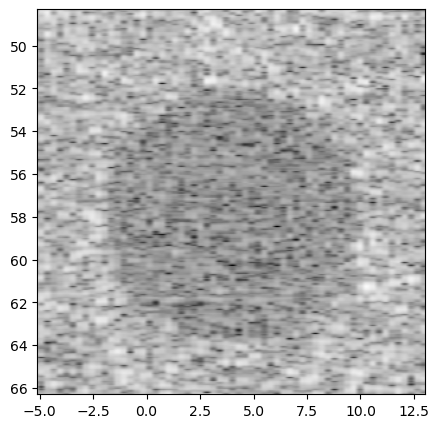

In [ ]:
tol = 1.51
plt.figure(figsize=(5, 5))
plt.imshow(target, cmap="gray", vmin=-60, vmax=0, extent=extent, origin="upper")
plt.xlim(-5.1, 13)
plt.ylim(66.3, 48.3)
plt.savefig('DAS_simu00040.png')


In [ ]:
cz

57.5

In [ ]:
h5_dir = r'C:\Users\smerino.C084288\Documents\simulatedCystDataset\downs800_0.0Att\raw'
simu_id = 5
simu_name = f'simu{simu_id:05d}'

P = LoadDataParams(h5_dir=h5_dir, simu_name=simu_name)
contrast_img, cnr_img, snr_img, gcnr_img = compute_metrics(P.pos_lat,P.pos_ax,P.radius, bmode_DAS, grid)
print(contrast_img, cnr_img, snr_img, gcnr_img)